In [123]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, precision_recall_curve, accuracy_score
from skimage.io import imread
from sklearn.model_selection import train_test_split

# sys.path.insert(0, "/mnt/Dados/Documentos/xgboost/python-package/")
import xgboost as xgb

from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif,chi2
from sklearn.preprocessing import Binarizer, scale, StandardScaler, minmax_scale

from sklearn.svm import SVC

import time

from sklearn.externals import joblib
import pandas as pd
from sklearn.manifold import Isomap, TSNE
from sklearn.model_selection import GroupKFold, LeavePGroupsOut, LeaveOneGroupOut

def shuffled(array):
    x = array.values.copy()
    np.random.shuffle(x)
    return x

def shuffled2(array):
    x = array.copy()
    np.random.shuffle(x)
    return x



In [2]:
%%time
# Read database from disk
data = pd.read_csv("../IC2017_DATA/augmented_2.csv")

CPU times: user 1min 43s, sys: 7.22 s, total: 1min 51s
Wall time: 1min 48s


In [3]:
# Shuffle data
# data = data.loc[shuffled(data.index)]

In [4]:
data.columns

Index(['ExG_contrast_np.pi/4', 'ExG_contrast_0', 'ExG_contrast_3*np.pi/2',
       'ExG_contrast_7*np.pi/4', 'ExG_correlation_np.pi/4',
       'ExG_correlation_0', 'ExG_correlation_3*np.pi/2',
       'ExG_correlation_7*np.pi/4', 'ExG_energy_np.pi/4', 'ExG_energy_0',
       ...
       'interior_61', 'interior_62', 'interior_63', 'target', 'img_num',
       'noise_num', 'rot_num', 'sh_num', 'block_num', 'base_num'],
      dtype='object', length=321)

In [5]:
y = data['target']
IMG = data['img_num']
BLOCK = data['block_num']
solo = data['base_num']

NOISE = data['noise_num']
ROT = data['rot_num']
SHIFT = data['sh_num']

In [6]:
# del data['target']
# del data['img_num']
# del data['block_num']
# del data['base_num']

# del data['noise_num']
# del data['rot_num']
# del data['sh_num']

In [7]:
data.drop(columns=['target', 'img_num', 'block_num', 'base_num', 'noise_num', 'rot_num', 'sh_num'], inplace=True)

In [8]:
df = data.loc[solo != 2]

In [9]:
devs = df.std()

In [10]:
del df

In [11]:
(devs == 0).sum()

48

In [12]:
remove = devs.loc[devs == 0].index # they are all BIC...
remove

Index(['border_3', 'border_7', 'border_12', 'border_19', 'border_28',
       'border_32', 'border_35', 'border_36', 'border_40', 'border_44',
       'border_48', 'border_49', 'border_50', 'border_51', 'border_52',
       'border_53', 'border_54', 'border_55', 'border_56', 'border_60',
       'border_61', 'interior_2', 'interior_3', 'interior_7', 'interior_12',
       'interior_13', 'interior_19', 'interior_28', 'interior_32',
       'interior_33', 'interior_34', 'interior_35', 'interior_36',
       'interior_39', 'interior_40', 'interior_44', 'interior_48',
       'interior_49', 'interior_50', 'interior_51', 'interior_52',
       'interior_53', 'interior_54', 'interior_55', 'interior_56',
       'interior_57', 'interior_60', 'interior_61'],
      dtype='object')

In [13]:
data.drop(columns=remove, inplace = True)

In [14]:
ORIGINAL = (NOISE == 0) & (ROT == 0) & (SHIFT == 0)

In [ ]:
# devs = data.std()
# (devs == 0).sum()
# # returns 48

# 0)  AUC and Mean Acc. Analysis of everything

In [15]:
def getBestTreshold(FPR, TPR, TH):
    """This function is for calculating the Mean Accuracy, given a ROC curve"""
    i_max = max(range(len(TPR)), key = lambda x : TPR[x] + 1 - FPR[x])
    mean_accuracy = (TPR[i_max] + 1 - FPR[i_max])/2
    return mean_accuracy, TH[i_max]

In [16]:
def getPerformance(true, prediction):
    auc = roc_auc_score(true, prediction)        
    fpr, tpr, th = roc_curve(true, prediction)
    if auc < .5:
        fpr, tpr = tpr, fpr
        auc = 1 - auc
    mean_acc, bestTH = getBestTreshold(fpr, tpr, th)
    return auc, mean_acc, bestTH, fpr, tpr

In [17]:
def splitByImages(data, test_size, repetitions):
    images = list(set(IMG.loc[data.index]))
    n = len(images)
    for _ in range(repetitions):
        np.random.shuffle(images)
        split_point = int(n * (1-test_size))
        yield images[:split_point], images[split_point:]

In [18]:
def XGBTrain(data, train_imgs, val_imgs, y):

    X_train, y_train = data.loc[IMG.isin(train_imgs)], y.loc[IMG.isin(train_imgs)]
    X_val, y_val = data.loc[IMG.isin(val_imgs)], y.loc[IMG.isin(val_imgs)]
    # print(len(train_imgs), len(val_imgs))
    
    ratio = float(np.sum(y_train == 1)) / np.sum(y_train==0)

    clf = xgb.XGBClassifier(
                    max_depth = 4,
                    n_estimators=1000,
                    learning_rate=0.2, 
                    nthread=10,
                    subsample=1.0,
                    colsample_bytree=1,
                    scale_pos_weight = ratio,
                    reg_alpha=0.03,
                    seed=1301)

    clf.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
            eval_set=[(X_val, y_val)], verbose = False)
    
    return clf

In [19]:
def XGBTrain2(data, train_imgs, val_imgs, y):
    
    X_train, y_train = data.loc[IMG.isin(train_imgs)], y.loc[IMG.isin(train_imgs)]
    mask = np.random.rand(len(X_train)) > .5
    X_train, y_train = X_train[mask], y_train[mask]
    
    X_val, y_val = data.loc[IMG.isin(val_imgs)], y.loc[IMG.isin(val_imgs)]
    # print(len(train_imgs), len(val_imgs))
    
    ratio = float(np.sum(y_train == 1)) / np.sum(y_train==0)

    clf = xgb.XGBClassifier(
                    max_depth = 4,
                    n_estimators=1000,
                    learning_rate=0.2, 
                    nthread=10,
                    subsample=1.0,
                    colsample_bytree=1,
                    scale_pos_weight = ratio,
                    reg_alpha=0.03,
                    seed=1301)

    clf.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
            eval_set=[(X_val, y_val)], verbose = False)
    
    return clf

In [20]:
LessCompact = [0]
MoreCompact = [1]
Calibrated = [0, 1]
NotCalibrated = [2]
experiments = [
#     [LessCompact, MoreCompact],
#     [MoreCompact, LessCompact],
    [Calibrated, NotCalibrated],
#     [NotCalibrated, Calibrated]
]

In [21]:
file = open('AccTest_augmented_results.txt', 'a')

In [22]:
%%time
n_reps = 3
auc_matrix = np.zeros((4, n_reps))
mac_matrix = np.zeros((4, n_reps))
auc_matrix_val = np.zeros((4, n_reps))
clfs = [[None] * n_reps] * 4 # 4 is the number of experiments

for e, (left, test) in enumerate(experiments):
    print("Experiment", left, test)
    print("Experiment", left, test, file = file)
    Xleft = data.loc[solo.isin(left)]
    Xtest = data.loc[solo.isin(test)]
    # print(len(Xleft), len(Xtest))
    
    
    for i, (train_imgs, val_imgs) in enumerate(splitByImages(Xleft, 1/4, n_reps)):
        # train
        clf = XGBTrain2(data, train_imgs, val_imgs, y)
        
        # get val performance of this trained model: ROC, AUC and MAc, and also the best threshold value for test
        mask = IMG.isin(val_imgs) & ORIGINAL
        prediction = clf.predict_proba(data.loc[mask])[:,-1]
        val_auc, val_mean_acc, bestTH, fpr, tpr = getPerformance(y.loc[mask], prediction)
        
        # get train either?
        
        # get test performance
        mask = solo.isin(test) & ORIGINAL
        prediction = clf.predict_proba(data.loc[mask])[:,-1]
        mean_acc = accuracy_score(y.loc[mask], 1 * (prediction > bestTH)) # 1 * array = array.astype(int)
        
               
        # save performance
        mac_matrix[e, i] = mean_acc
        auc_matrix_val[e, i] = clf.best_score
        
        # save classifiers for further analysis
#         clfs[e][i] = clf
        
        print(" > %d iterations \t Val vs Test (MAc) = %.3f vs %.3f" % (clf.best_iteration, 
                                                                               val_mean_acc, mean_acc))
        print(" > %d iterations \t Val vs Test (MAc) = %.3f vs %.3f" % (clf.best_iteration, 
                                                                               val_mean_acc, mean_acc), file = file)
        
print("Done.")  
file.close()

Experiment [0, 1] [2]
 > 14 iterations 	 Val vs Test (MAc) = 0.929 vs 0.712
 > 35 iterations 	 Val vs Test (MAc) = 0.949 vs 0.709
 > 51 iterations 	 Val vs Test (MAc) = 0.933 vs 0.714
Done.
CPU times: user 43min 52s, sys: 3min 7s, total: 46min 59s
Wall time: 6min 52s


In [ ]:
"""
Experiment [0, 1] [2]
 > 48 iterations 	 Val vs Test (MAc) = 0.949 vs 0.717
 > 48 iterations 	 Val vs Test (MAc) = 0.961 vs 0.716
 > 19 iterations 	 Val vs Test (MAc) = 0.920 vs 0.714
Done.

"""

In [ ]:
# keep a base image for prediction -> just zeros
# expand predictions into images
# fix position
# add predictions, and normalize in the end

In [23]:
from scipy.ndimage.interpolation import rotate

In [24]:
pred = np.zeros((512, 512))

In [25]:
paths = pd.read_csv('../IC2017_DATA/valid_images.csv')

In [ ]:
paths

In [37]:
rotations = [
    (0, 0),
    (1, 15),
    (2, 30),
    (3, 45),
]

shifts = [
    (0, 0, 0),
    (1, 0, 1),
    (2, 1, 0),
    (3, 1, 1),
]

img = 49
rot = 3
shift = 2
noise = 0

examp = data.loc[(IMG == img) & (ROT == rot) & (SHIFT == shift) & (NOISE == noise)]

rot_num, rot_val = rotations[rot]
sh_num, sh_val_v, sh_val_h = shifts[shift]

In [38]:
# shift 2 appears to be 3. I have no idea what 3 is.. somehow it is 30x 30

In [39]:
examp.shape

(1980, 266)

In [40]:
curr = clf.predict_proba(examp)[:,-1]

In [41]:
if sh_val_v != sh_val_h:
    x = (-1 + np.sqrt(1 + 4 * len(examp))) / 2
    x = int(x)
    if sh_val_h:
        a, b = x + 1, x
    else:
        a, b = x, x + 1
else:
    a = b = int(np.sqrt(len(examp)))
a, b

(44, 45)

(704, 720)

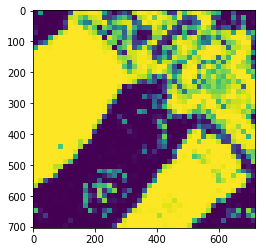

In [42]:
curr = curr.reshape(a, b)
curr = np.repeat(curr, 16, axis = 0)
curr = np.repeat(curr, 16, axis = 1)
plt.imshow(curr)
curr.shape

In [63]:
rot = rotate(curr, -rot_val, reshape = False)

(704, 720)

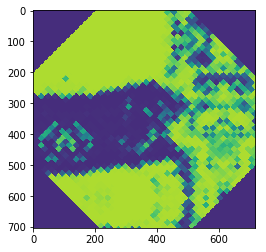

In [68]:
plt.imshow(rot)
rot.shape

In [70]:
v, h = curr.shape
dv = (512 - 16) if sh_val_v else 512
dh = (512 - 16) if sh_val_h else 512

v, h = (v - dv) // 2, (h - dh) //2

(104, 104, 496, 512)

In [71]:
temp = rot[v : v + dv, h : h + dh]
temp.shape

(496, 512)

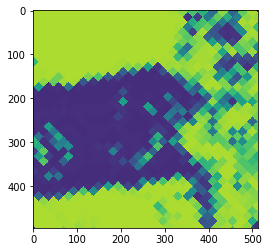

In [72]:
plt.imshow(temp)

In [109]:
def unrot(curr, rot_val, sh_val_v, sh_val_h):
    rot = rotate(curr, -rot_val, reshape = False)
    v, h = curr.shape
    dv = (512 - 16) if sh_val_v else 512
    dh = (512 - 16) if sh_val_h else 512
    v, h = (v - dv) // 2, (h - dh) //2

    return rot[v : v + dv, h : h + dh]

In [110]:
def reverse(data, clf, img_num, noise, rotation, shift):
    
    noise_num, noise_val = noise
    rot_num, rot_val = rotation
    sh_num, sh_val_v, sh_val_h = shift
    
    curr = data.loc[(IMG == img_num) & (ROT == rot_num) & (SHIFT == sh_num) & (NOISE == noise_num)]
    curr = clf.predict_proba(curr)[:,-1]
    
    if sh_val_v != sh_val_h:
        x = (-1 + np.sqrt(1 + 4 * len(curr))) / 2
        x = int(x)
        if sh_val_h:
            a, b = x + 1, x
        else:
            a, b = x, x + 1
    else:
        a = b = int(np.sqrt(len(curr)))
    

    curr = curr.reshape(a, b)
    curr = np.repeat(curr, 16, axis = 0)
    curr = np.repeat(curr, 16, axis = 1)
    
    if rot_num != 0:
        curr = unrot(curr, rot_val, sh_val_v, sh_val_h)

    
    return curr
    

In [111]:
rotations = [
    (0, 0),
    (1, 15),
    (2, 30),
    (3, 45),
]

shifts = [
    (0, 0, 0),
    (1, 0, 1),
    (2, 1, 0),
    (3, 1, 1),
]

noises = [
    (0, 'None'),
    (1, 'Blur')
]

In [119]:
%%time
img_num = 49

pred = np.zeros((512, 512))
aux = np.zeros((512, 512))

for noise in noises:
    for rotation in rotations:
        for shift in shifts:
#             if rotation[0] != 0:
#                 continue
#             print(noise, rotation, shift)
            curr = reverse(data, clf, img_num, noise, rotation, shift)
            sh_num, sh_val_v, sh_val_h = shift
            a = sh_val_v * 8
            b = sh_val_h * 8
#             print(curr.shape)
            pred[a : 512 - a, b : 512 - b] += curr
            aux[a : 512 - a, b : 512 - b] += 1
pred /= aux


CPU times: user 11.9 s, sys: 12.9 s, total: 24.8 s
Wall time: 3.54 s


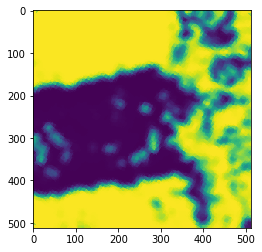

In [120]:
plt.imshow(pred)

In [142]:
orig = reverse(data, clf, img_num, noises[0], rotations[0], shifts[0])

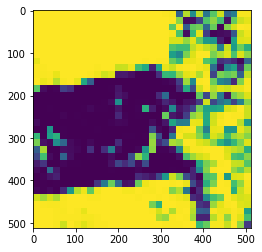

In [143]:
plt.imshow(orig)

In [41]:
if sh_val_v != sh_val_h:
    x = (-1 + np.sqrt(1 + 4 * len(examp))) / 2
    x = int(x)
    if sh_val_h:
        a, b = x + 1, x
    else:
        a, b = x, x + 1
else:
    a = b = int(np.sqrt(len(examp)))
a, b

(44, 45)

(704, 720)

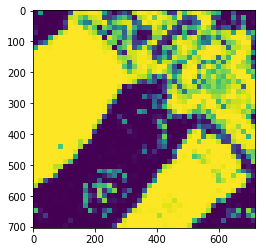

In [42]:
curr = curr.reshape(a, b)
curr = np.repeat(curr, 16, axis = 0)
curr = np.repeat(curr, 16, axis = 1)
plt.imshow(curr)
curr.shape

In [139]:
gt = imread(paths.query('num == @img_num')['gt'].values[0], as_gray=True) 

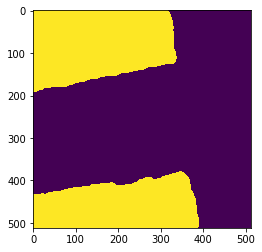

In [140]:
plt.imshow(gt)

In [144]:
roc_auc_score(gt.flatten(), orig.flatten())

0.9394538122944347

In [145]:
roc_auc_score(gt.flatten(), pred.flatten())

0.944326257109855

Image 40
[AUC] fusion vs single : 0.971 vs 0.953 (+0.018)
[MAc] fusion vs single : 0.463 vs 0.454 (+0.008)


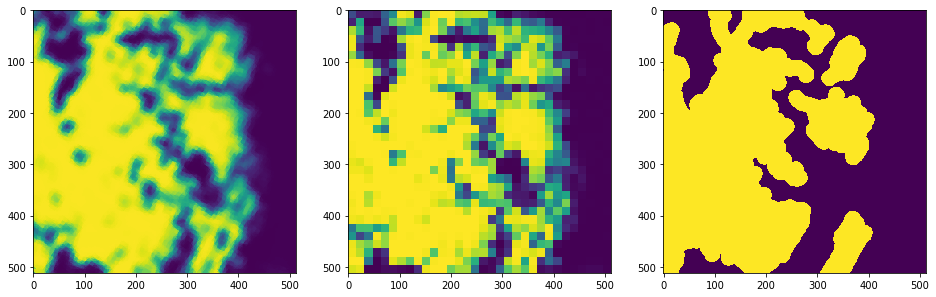

Image 41
[AUC] fusion vs single : 0.960 vs 0.949 (+0.011)
[MAc] fusion vs single : 0.674 vs 0.659 (+0.015)


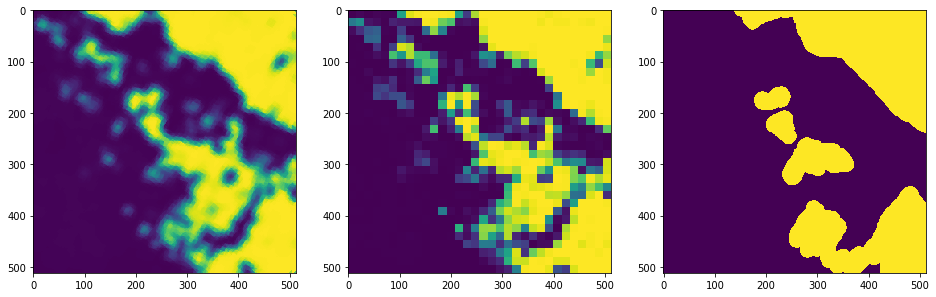

Image 42
can't compute
[MAc] fusion vs single : 0.999 vs 0.998 (+0.001)


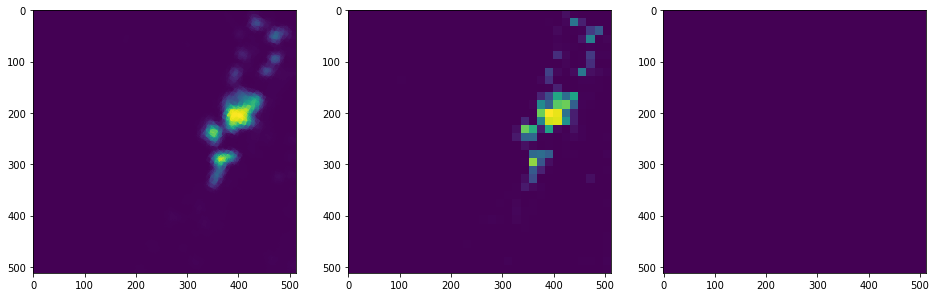

Image 43
can't compute
[MAc] fusion vs single : 1.000 vs 1.000 (+0.000)


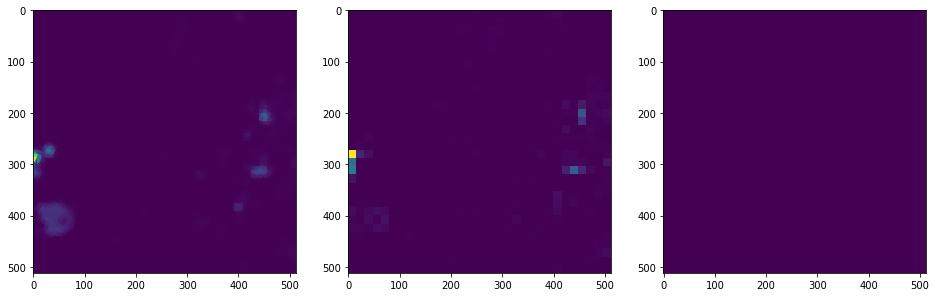

Image 44
can't compute
[MAc] fusion vs single : 0.994 vs 0.983 (+0.010)


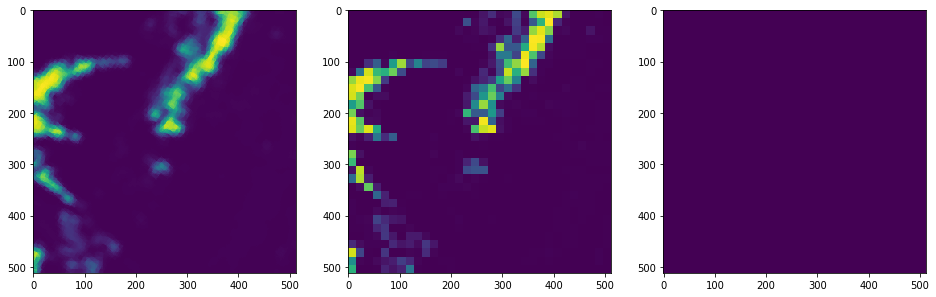

Image 45
[AUC] fusion vs single : 0.996 vs 0.987 (+0.009)
[MAc] fusion vs single : 0.964 vs 0.963 (+0.001)


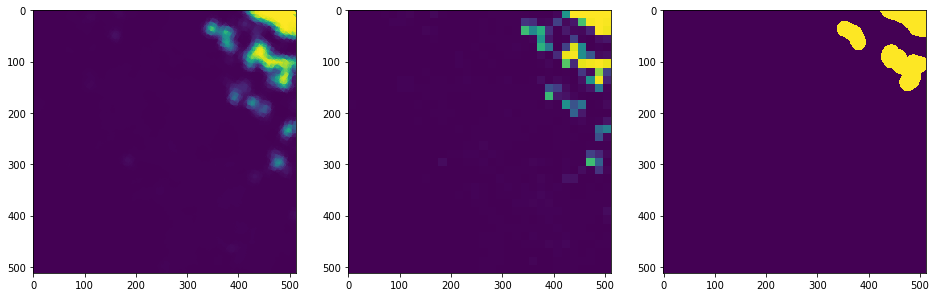

Image 46
[AUC] fusion vs single : 0.968 vs 0.957 (+0.011)
[MAc] fusion vs single : 0.717 vs 0.703 (+0.014)


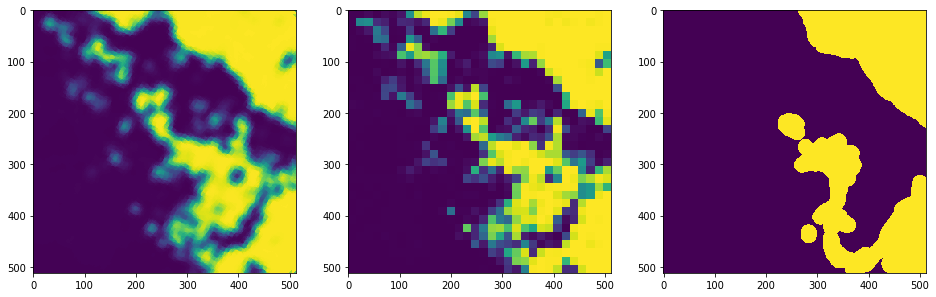

Image 47
[AUC] fusion vs single : 0.993 vs 0.988 (+0.005)
[MAc] fusion vs single : 0.728 vs 0.726 (+0.002)


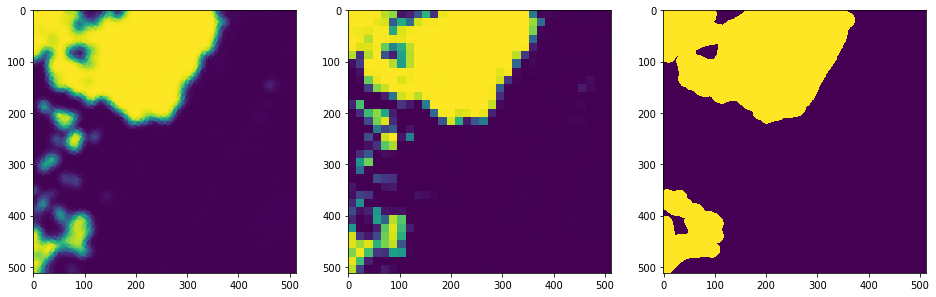

Image 48
can't compute
[MAc] fusion vs single : 0.931 vs 0.745 (+0.186)


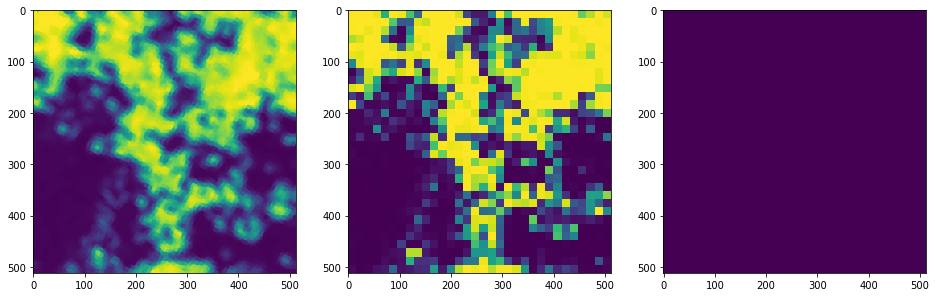

Image 49
[AUC] fusion vs single : 0.944 vs 0.939 (+0.005)
[MAc] fusion vs single : 0.565 vs 0.543 (+0.022)


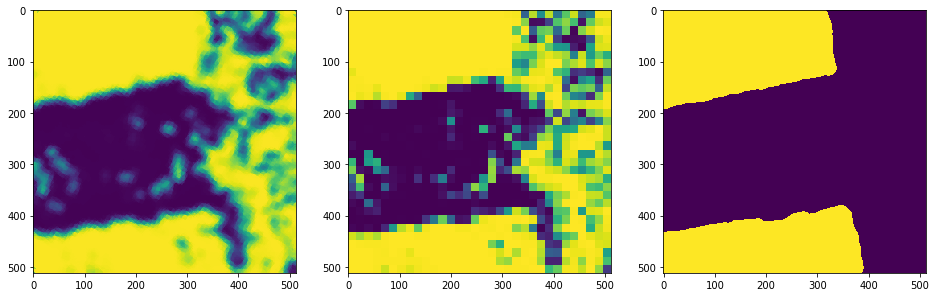

Image 50
[AUC] fusion vs single : 0.855 vs 0.823 (+0.033)
[MAc] fusion vs single : 0.354 vs 0.299 (+0.055)


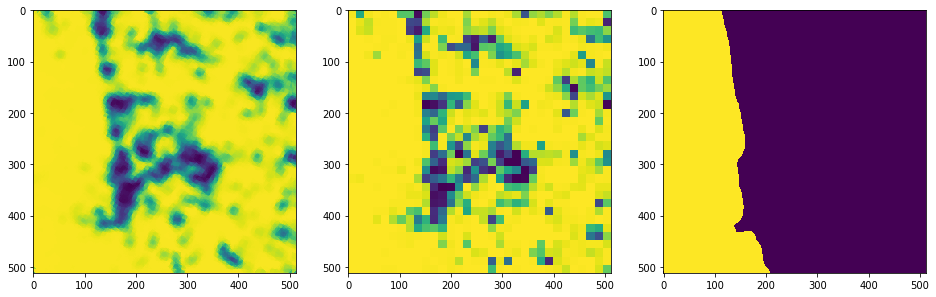

Image 51
[AUC] fusion vs single : 0.999 vs 0.997 (+0.002)
[MAc] fusion vs single : 0.642 vs 0.639 (+0.004)


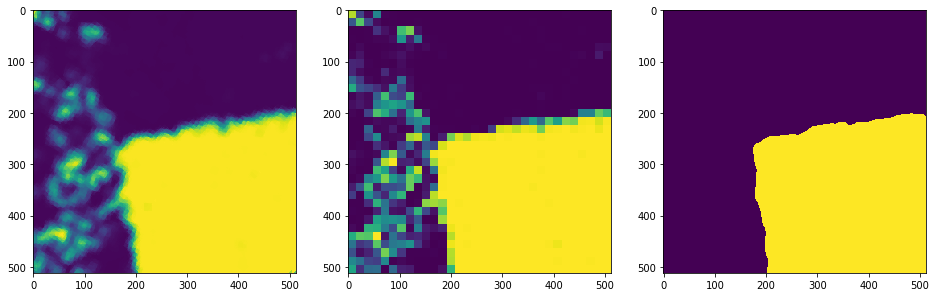

Image 52
[AUC] fusion vs single : 0.878 vs 0.847 (+0.031)
[MAc] fusion vs single : 0.337 vs 0.337 (+0.000)


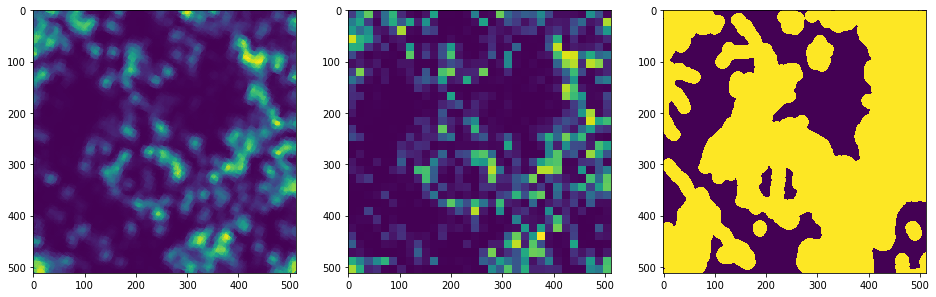

Image 53
[AUC] fusion vs single : 0.999 vs 0.997 (+0.002)
[MAc] fusion vs single : 0.532 vs 0.532 (+0.000)


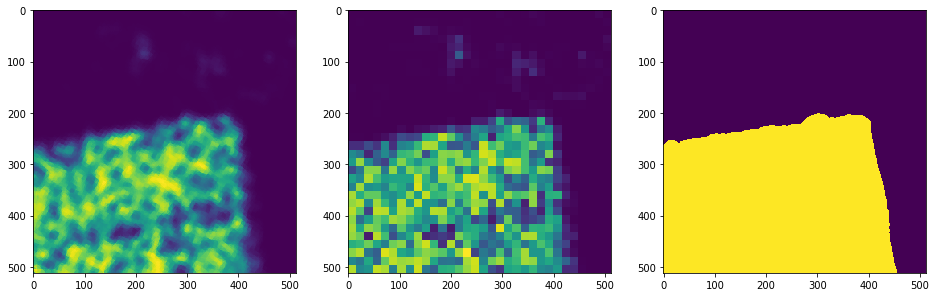

Image 54
[AUC] fusion vs single : 0.979 vs 0.964 (+0.015)
[MAc] fusion vs single : 0.027 vs 0.027 (+0.000)


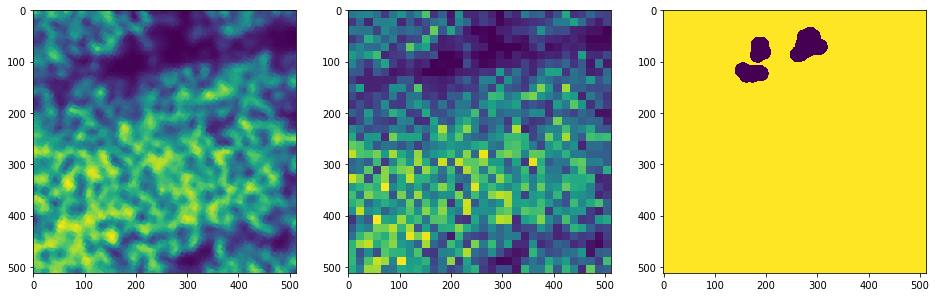

Image 55
[AUC] fusion vs single : 0.978 vs 0.961 (+0.017)
[MAc] fusion vs single : 0.035 vs 0.035 (+0.000)


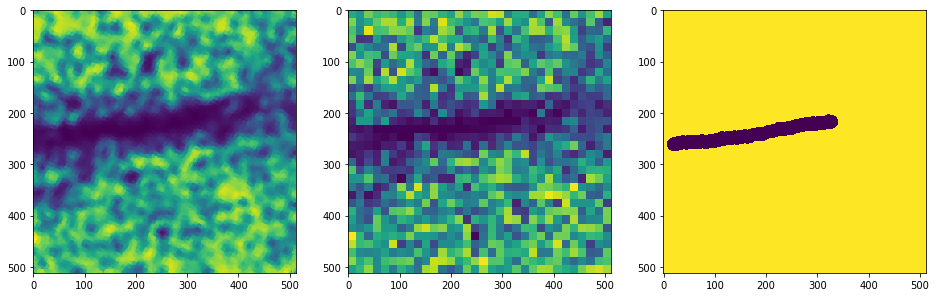

Image 56
[AUC] fusion vs single : 1.000 vs 0.998 (+0.001)
[MAc] fusion vs single : 0.600 vs 0.600 (+0.000)


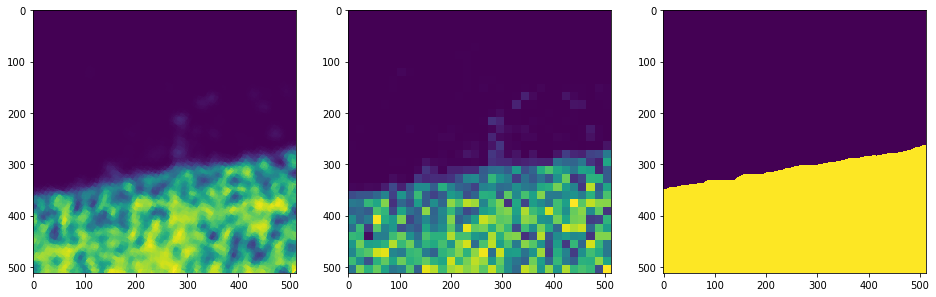

Image 57
[AUC] fusion vs single : 0.988 vs 0.978 (+0.011)
[MAc] fusion vs single : 0.887 vs 0.881 (+0.006)


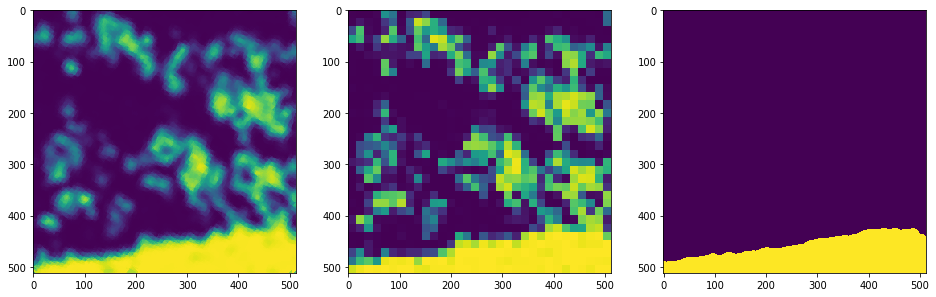

Image 58
[AUC] fusion vs single : 0.999 vs 0.995 (+0.004)
[MAc] fusion vs single : 0.605 vs 0.605 (+0.000)


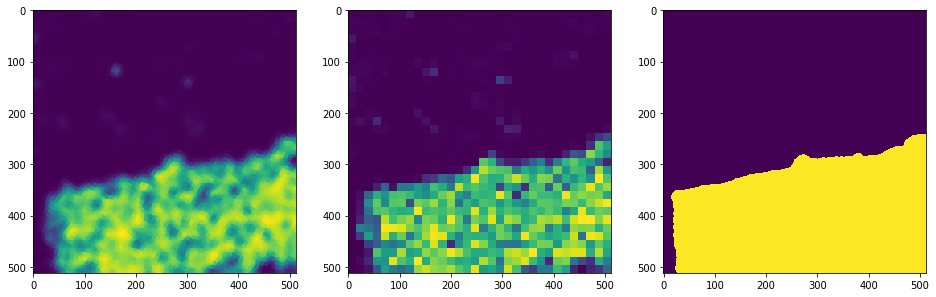

Image 59
[AUC] fusion vs single : 0.840 vs 0.811 (+0.029)
[MAc] fusion vs single : 0.304 vs 0.304 (+0.000)


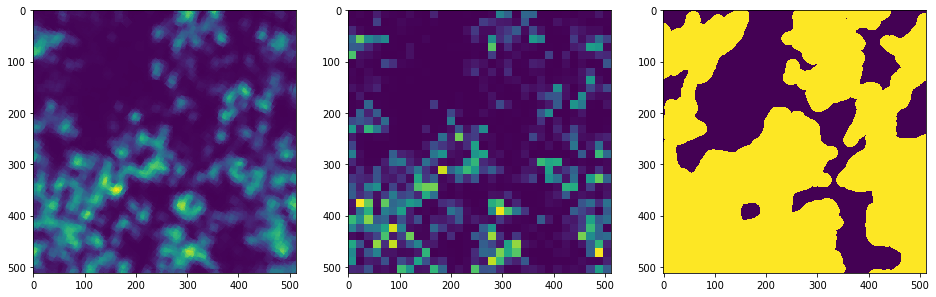

Image 60
[AUC] fusion vs single : 0.958 vs 0.944 (+0.015)
[MAc] fusion vs single : 0.654 vs 0.654 (+0.000)


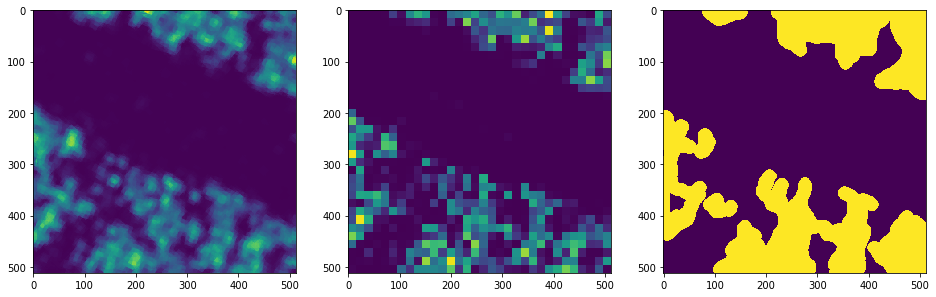

Image 61
can't compute
[MAc] fusion vs single : 0.998 vs 0.993 (+0.005)


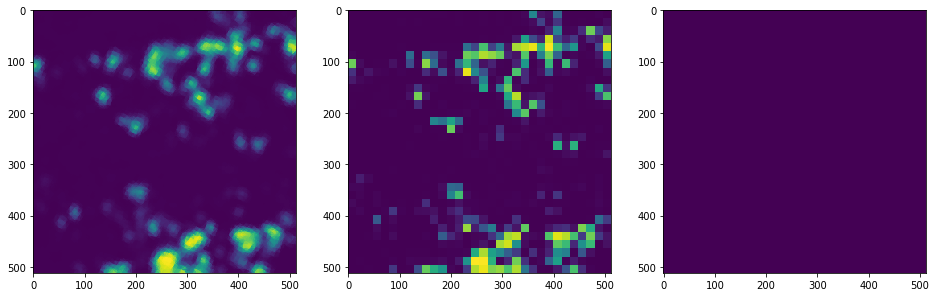

In [159]:
for img_num in IMG.loc[solo == 2].unique():
    print('Image', int(img_num))
    
    pred = np.zeros((512, 512))
    aux = np.zeros((512, 512))

    for noise in noises:
        for rotation in rotations:
            for shift in shifts:
    #             if rotation[0] != 0:
    #                 continue
    #             print(noise, rotation, shift)
                curr = reverse(data, clf, img_num, noise, rotation, shift)
                sh_num, sh_val_v, sh_val_h = shift
                a = sh_val_v * 8
                b = sh_val_h * 8
    #             print(curr.shape)
                pred[a : 512 - a, b : 512 - b] += curr
                aux[a : 512 - a, b : 512 - b] += 1
    pred /= aux
    
    orig = reverse(data, clf, img_num, noises[0], rotations[0], shifts[0])
    gt = imread(paths.query('num == @img_num')['gt'].values[0], as_gray=True)
    
    try:
        snew = roc_auc_score(gt.flatten(), pred.flatten())
        sold = roc_auc_score(gt.flatten(), orig.flatten())
        print('[AUC] fusion vs single : %.3f vs %.3f (%+.3f)' % (snew, sold, snew - sold))
    except:
        print('can\'t compute')
        
    snew = accuracy_score(gt.flatten(), 1 * (pred.flatten() > bestTH))
    sold = accuracy_score(gt.flatten(), 1 * (orig.flatten() > bestTH))
    print('[MAc] fusion vs single : %.3f vs %.3f (%+.3f)' % (snew, sold, snew - sold))
    
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(pred)
    plt.subplot(1, 3, 2)
    plt.imshow(orig)
    plt.subplot(1, 3, 3)
    plt.imshow(gt)
    plt.show()
    
    
    

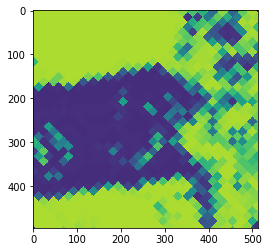

In [77]:
plt.imshow(curr)

'../IC2017_DATA/newimages_lcrs2/gts/gtdeg09.png'

In [ ]:
for e, (left, test) in enumerate(experiments):
    print("Experiment", left, test)
    print("Experiment", left, test, file = file)
    Xleft = data.loc[solo.isin(left)]
    Xtest = data.loc[solo.isin(test)]
    for i, (train_imgs, val_imgs) in enumerate(splitByImages(Xleft, 1/4, n_reps)):
        
        print(" > %d iterations \t Val vs Test (MAc) = %.3f vs %.3f" % (clf.best_iteration, 
                                                                               val_mean_acc, mean_acc))

In [ ]:
# Plot ROC curves for each soil for all columns
# and save AUC and MAc for each soil for all columns in two separate dataframes

scores_auc = pd.DataFrame(None, columns = [0, 1, 2], index=data.columns)
scores_mac = pd.DataFrame(None, columns = [0, 1, 2], index=data.columns)
for soil in range(3):
    plt.figure(figsize=(12,9))
    print("\nsolo:", soil)
    
    for col in data.columns:
        score = roc_auc_score(y.loc[solo == soil], data.loc[solo == soil][col])
        fpr, tpr, th = roc_curve(y.loc[solo == soil], data.loc[solo == soil][col])
        if score < .5:
            fpr, tpr = tpr, fpr
            score = 1 - score
        mean_acc, _ = getBestTreshold(fpr, tpr, th)

        scores_auc.loc[col, soil] = score
        scores_mac.loc[col, soil] = mean_acc

        #print(" > %-30s AUC = %.3f \t MeanAcc = %.3f" % (col, score, mean_acc))
        plt.plot(fpr, tpr)

    plt.ylim((0,1))
    plt.xlim((0,1))
    plt.plot([0,1], [0,1], "k--")
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.show()


In [ ]:
scores_mac["amean"] = scores_mac[[0,1,2]].mean(axis=1)
scores_mac["min"] = scores_mac[[0,1,2]].min(axis=1)
#scores_mac["gmean"] = np.power(scores_mac[[0,1,2]].prod(axis=1) , 1/3)

In [ ]:
best_features = scores_mac.sort_values("min", ascending=False)[[0,1,2]].iloc[:10]
pyperclip.copy(best_features.to_latex())
best_features

In [ ]:
cols = scores_mac.sort_values("min", ascending=False)[[0,1,2]].iloc[:10].index
plt.figure(figsize=(16,5))
for soil in range(3):
    plt.subplot(1,3,soil+1)
    
    for col in cols:
        score = roc_auc_score(y.loc[solo == soil], data.loc[solo == soil][col])
        fpr, tpr, th = roc_curve(y.loc[solo == soil], data.loc[solo == soil][col])
        if score < .5:
            fpr, tpr = tpr, fpr
            score = 1 - score
            
        #print(" > %-30s AUC = %.3f \t MeanAcc = %.3f" % (col, score, mean_acc))
        plt.plot(fpr, tpr, label = col)
    plt.title("Solo %d" % soil)
    plt.ylim((0,1))
    plt.xlim((0,1))
    plt.plot([0,1], [0,1], "k--")
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.legend(loc = 4)
plt.savefig("report1/figures/10bestminfeatures.png")

In [ ]:
scores_mac.sort_values(2, ascending=False)[2].iloc[:10]

In [156]:
bestTH

0.942797

{40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0}

# 1) Check VI discriminant capability

### In this section, we check the AUC, Mean Accuracy and ROC curves for each VI in each soil type (0, 1, 2)

In [ ]:
names_VI = ["ExG", "ExGR", "CIVE", "VEG", "WI", "NGRDI"]

In [ ]:
VI_cols = [name + "_mean" for name in names_VI]

In [ ]:
# Get only columns with mean of VI values of 16x16 regions
VI_data = data[[name + "_mean" for name in names_VI]]

In [ ]:
"""
for each generalization test:
    separate into test and rest (how many times?)
    separate rest into train and val (how many times?)
    find best th value and best VI (which mean: keep the VI used and the TH.
        > maybe save all in a table and then order it
    test the best
"""

In [ ]:
mac_matrix = np.zeros((4, reps))
VI_scores = [{name + "_mean" : None for name in names_VI}] * 4 # 4 is the number of experiments

for e, (left, test) in enumerate(experiments):
    print("Experiment", left, test)
    Xleft = data.loc[solo.isin(left)]
    Xtest = data.loc[solo.isin(test)]
    
    
    for col in VI_cols:
        
        # get val performance of this trained model: ROC, AUC and MAc, and also the best threshold value for test
        prediction = Xleft[col]
        val_auc, val_mean_acc, bestTH, fpr, tpr = getPerformance(y.loc[solo.isin(left)], prediction)

        
        # get test performance
        prediction = Xtest[col]
        mean_acc = accuracy_score(y.loc[solo.isin(test)], 1 * (prediction > bestTH)) # 1 * array = array.astype(int)
        if col == "CIVE_mean":
            mean_acc = accuracy_score(y.loc[solo.isin(test)], 1 * (prediction < bestTH))
        
               
        # save performance
        VI_scores[e][col] = mean_acc
        
        print(" > %s \t Val vs Test (MAc) = %.3f vs %.3f" % (col, val_mean_acc, mean_acc))
        
print("Done.")    

In [ ]:
n_reps = 5
auc_matrix = np.zeros((4, reps))
mac_matrix = np.zeros((4, reps))
auc_matrix_val = np.zeros((4, reps))
clfs = [[None] * n_reps] * 4 # 4 is the number of experiments

for e, (left, test) in enumerate(experiments):
    print("Experiment", left, test)
    Xleft = data.loc[solo.isin(left)]
    Xtest = data.loc[solo.isin(test)]
    
    
    for i, (train_imgs, val_imgs) in enumerate(splitByImages(Xleft, 1/4, n_reps)):
        # train
        clf = XGBTrain(data, train_imgs, val_imgs, y)
        
        # get val performance of this trained model: ROC, AUC and MAc, and also the best threshold value for test
        prediction = clf.predict_proba(data.loc[IMG.isin(val_imgs)])[:,-1]
        val_auc, val_mean_acc, bestTH, fpr, tpr = getPerformance(y.loc[IMG.isin(val_imgs)], prediction)
        
        # get train either?
        
        # get test performance
        prediction = clf.predict_proba(data.loc[solo.isin(test)])[:,-1]
        mean_acc = accuracy_score(y.loc[solo.isin(test)], 1 * (prediction > bestTH)) # 1 * array = array.astype(int)
        
               
        # save performance
        mac_matrix[e, i] = mean_acc
        auc_matrix_val[e, i] = clf.best_score
        
        # save classifiers for further analysis
        clfs[e][i] = clfs
        
        print(" > %d iterations \t Val vs Test (MAc) = %.3f vs %.3f" % (clf.best_iteration, 
                                                                               val_mean_acc, mean_acc))
        
print("Done.")    

# Análise do Resultados

In [ ]:
clf_ind = 2 # base 2 out is better to find out why training in 0 and 1 fail in generalizing to 2
clf = clfs[clf_ind][0]

train_index, test_index = splits[clf_ind]
X_train, y_train = data.iloc[train_index], y.iloc[train_index]
X_test, y_test = data.iloc[test_index], y.iloc[test_index]

predict = clf.predict_proba(X_test, ntree_limit=clf.best_iteration)[:,-1]

In [ ]:
plt.figure(figsize=(12,9))
for col in scores_mac[2].sort_values(ascending=False).index[:10]:
    score = roc_auc_score(y.loc[solo==2], data.loc[solo==2][col])
    fpr, tpr, th = roc_curve(y.loc[solo==2], data.loc[solo==2][col])
    if score < .5:
        fpr, tpr = tpr, fpr
        score = 1 - score
    mean_acc, _ = getBestTreshold(fpr, tpr, th)
    print(" > %-30s AUC = %.3f \t MeanAcc = %.3f" % (col, score, mean_acc))
    plt.plot(fpr, tpr, label = col)

score = roc_auc_score(y_test, predict)   
FPR, TPR, TH = roc_curve(y_test, predict)
mean_acc, _ = getBestTreshold(FPR, TPR, TH)
print(" > %-30s AUC = %.3f \t MeanAcc = %.3f" % ("predict", score, mean_acc))
plt.plot(FPR,TPR, "k-", label = "predict", lw = 1.5)

plt.title("Top 10 features with higher minimum Mean Accuracy in all three bases vs Learning")
plt.ylim((0,1))
plt.xlim((0,1))
plt.plot([0,1], [0,1], "k--")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend();
plt.savefig("report1/figures/prediction_vs_bestFeatures.png")

In [ ]:
plt.figure(figsize=(12,9))
for col in importance_single[2].sort_values(ascending=False)[:10].index:
    score = roc_auc_score(y.loc[solo==2], data.loc[solo==2][col])
    fpr, tpr, th = roc_curve(y.loc[solo==2], data.loc[solo==2][col])
    if score < .5:
        fpr, tpr = tpr, fpr
        score = 1 - score
    mean_acc, _ = getBestTreshold(fpr, tpr, th)
    print(" > %-30s AUC = %.3f \t MeanAcc = %.3f" % (col, score, mean_acc))
    plt.plot(fpr, tpr, label = col)

score = roc_auc_score(y_test, predict)   
FPR, TPR, TH = roc_curve(y_test, predict)
mean_acc, _ = getBestTreshold(FPR, TPR, TH)
print(" > %-30s AUC = %.3f \t MeanAcc = %.3f" % ("predict", score, mean_acc))
plt.plot(FPR,TPR, "k-", label = "predict", lw = 1.5)

plt.title("Top 10 features with higher minimum importace value in all three bases vs Learning")
plt.ylim((0,1))
plt.xlim((0,1))
plt.plot([0,1], [0,1], "k--")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend()
plt.savefig("report1/figures/10bestminGAIN_vs_predict")

In [ ]:
plt.figure(figsize=(17,5))
plt.scatter(predict, y_test, alpha = .1)
th = TH[th_ix]
plt.plot([th, th], [1,0], "r-")

In [ ]:
train_pred = clf.predict_proba(data, ntree_limit=clf.best_iteration)[:,-1]

In [ ]:
m1 = ((y == 1) & (train_pred < th))
m0 = ((y == 0) & (train_pred > th))
m1.sum(), m0.sum()

In [ ]:
dec = PCA()

In [ ]:
pca = dec.fit_transform(StandardScaler().fit_transform(data.fillna(10**-5)))

In [ ]:
plt.figure(figsize=(17,5))
xvr = dec.explained_variance_ratio_[:30]
plt.bar(range(len(xvr)), np.cumsum(xvr))

In [ ]:
plt.figure(figsize=(12,5))
for c in {0,1}:
    plt.subplot(1,2,c+1)
    plt.scatter(pca[y==(1-c),0], pca[y==(1-c),1], alpha = 0 * .2, label = "classe %d" % (1-c))
    plt.scatter(pca[y==c,0], pca[y==c,1], alpha = .2, label = "classe %d" % c, color = "blue" if c == 0 else "yellow")
    plt.plot([0,0], [pca[:,1].min(), pca[:,1].max()], "r--")
    plt.plot([pca[:,0].min(), pca[:,0].max()], [0,0], "r--")
    plt.legend()

In [ ]:
plt.figure(figsize=(12,9))
for c in {0,1}:
    plt.scatter(pca[y==c,0], pca[y==c,1], alpha = .2, label = "classe %d" % c)
plt.scatter(pca[m0,0], pca[m0,1], label = "miss0")
plt.scatter(pca[m1,0], pca[m1,1], label = "miss1")
plt.legend()

In [ ]:
from skimage.util.shape import view_as_blocks
from skimage.io import imread


In [ ]:
paths = ["imgs_orig", "gts_orig"] # TROCAR AQUI DEPENDENDO DA BASE

path_imgs = sorted([ paths[0] + '/' + i for i in listdir(paths[0]) ])
path_gts = sorted([ paths[1] + '/' + i for i in listdir(paths[1]) ])


paths2 = ["imgs", "gts"] # TROCAR AQUI DEPENDENDO DA BASE

path_imgs2 = sorted([ paths2[0] + '/' + i for i in listdir(paths2[0]) ])
path_gts2 = sorted([ paths2[1] + '/' + i for i in listdir(paths2[1]) ])

In [ ]:
misses = pd.concat([IMG[m0].value_counts().rename("NOVEG-miss"), IMG[m1].value_counts().rename("VEG-miss")], axis = 1).fillna(0)

In [ ]:
misses["sum"] = misses["NOVEG-miss"] + misses["VEG-miss"]

In [ ]:
misses.sort_values("sum",ascending=False)

In [ ]:
def highlight(ind, color):
    x_ini = (ind % 32) * 16
    x_end = x_ini + 15
    y_ini = (ind // 32) * 16
    y_end = y_ini + 15
    plt.fill_between([x_ini, x_end], y_ini, y_end, alpha =.4, color = color)

In [ ]:
i = 41
if i >= 40:
    img = imread(path_imgs2[i-40])
    gt = imread(path_gts2[i-40], as_grey=True)
else:
    img = imread(path_imgs[i])
    gt = imread(path_gts[i], as_grey=True)


In [ ]:
plt.figure(figsize=(16,7))
plt.subplots_adjust(wspace = 0, hspace = 0)

plt.subplot(1,2,1)
plt.imshow(img)
for b in BLOCK[(IMG == i) & m1]:
    highlight(b, "red")
for b in BLOCK[(IMG == i) & m0]:
    highlight(b, "blue")
plt.ylim((511,0))
plt.xlim((0,511))

plt.subplot(1,2,2)
plt.imshow(gt)
for b in BLOCK[(IMG == i) & (y == 1)]:
    highlight(b, "green")
plt.ylim((511,0))
plt.xlim((0,511))

plt.savefig("report1/figures/errovisu%02d.png" % i)